In [2]:
import pandas as pd
import numpy as np
from osgeo import ogr,osr

from matplotlib import pyplot as plt
import os

from kpmb_weather import download_weather_data


weatherstation_dist = 50 # km

volume = 'Data'
volume = 'My Passport for Mac'

### Read in NOAA weather station tables

In [3]:
dfcode = pd.read_csv(f'/Volumes/{volume}/WeatherData/NOAA/MSHR_Enhanced_Table.csv')
colspecs = dfcode.POSITION.apply(lambda x: (int(x.split('-')[0])-1,int(x.split('-')[1])))

dfstations_NOAA = pd.read_fwf(f'/Volumes/{volume}/WeatherData/NOAA/mshr_enhanced_202102.txt',
                         names=dfcode.FIELD.values, dtypes=object,
                         colspecs=list(colspecs))
# remove balloon stations
dfstations_NOAA = dfstations_NOAA[~dfstations_NOAA.LAT_DEC.isnull() & ~dfstations_NOAA.LON_DEC.isnull()]

In [4]:
NOAA_SHAPEFILE = f'/Volumes/{volume}/WeatherData/NOAA/stations.shp'

if os.path.exists(NOAA_SHAPEFILE):
    pass
else:
    driver = ogr.GetDriverByName('ESRI Shapefile')
    data_source = driver.CreateDataSource(NOAA_SHAPEFILE)
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(4326)

    # create the layer
    layer = data_source.CreateLayer('stations',srs,ogr.wkbPoint)

    dtypes_dict = {'|O':ogr.OFTString,
                   '<i8':ogr.OFTInteger,
                  '<f8':ogr.OFTReal}

    for c,d in dfstations_NOAA[['GHCND_ID','LAT_DEC','LON_DEC']].drop_duplicates().dtypes.iteritems():
        print(c,d.str)
        ogr_type = dtypes_dict[d.str]
        field_name = ogr.FieldDefn(c,ogr_type)
        layer.CreateField(field_name)

    for i,row in dfstations_NOAA[['GHCND_ID','LAT_DEC','LON_DEC']].drop_duplicates().iterrows():
        feature = ogr.Feature(layer.GetLayerDefn())
        for c in ['GHCND_ID','LAT_DEC','LON_DEC']:
            feature.SetField(c,row[c])
        #print(row.LON_DEC, row.LAT_DEC, row.GHCND_ID)
        wkt = f"POINT({row.LAT_DEC} {row.LON_DEC})"
        point = ogr.CreateGeometryFromWkt(wkt)
        feature.SetGeometry(point)
        layer.CreateFeature(feature)
        feature = None
    data_source = None

### Read in US lakes coordinates

In [5]:
dftopN = pd.read_csv(f'/Volumes/{volume}/IceModels/topUSlakes.csv')
lat_lakes, lon_lakes = dftopN[['lat','lon']].T.values

Create a buffer region of 50 km around each lake representative point in which to search for stations

In [6]:
max_station_distance = weatherstation_dist * 1e3 # converted metres
# transform from lat/lon to easting/northing, buffer and return back to lat/lon
local_utm = 32618

source = osr.SpatialReference()
source.ImportFromEPSG(4326)
target = osr.SpatialReference()
target.ImportFromEPSG(local_utm)

transform = osr.CoordinateTransformation(source,target)
inverse_transform = osr.CoordinateTransformation(target,source)

multipoint = ogr.Geometry(ogr.wkbMultiPoint)

# run through all lat lon coordinates
for lat,lon in zip(lat_lakes, lon_lakes):
    #print(lat,lon)
    point = ogr.CreateGeometryFromWkt(f"POINT ({lat} {lon})")
    point.Transform(transform)
    multipoint.AddGeometry(point)
    
buffered_multipoint = multipoint.Buffer(max_station_distance)
buffered_multipoint.Transform(inverse_transform)

ds = ogr.Open(NOAA_SHAPEFILE)
layer = ds.GetLayer()
layer.SetSpatialFilter(buffered_multipoint)

# Get a list of weather stations within 50 km of sample sites
weatherStations = []
for feat in layer:
    weatherStations.append(feat.GetField('GHCND_ID'))

In [7]:
dfstations = dfstations_NOAA[dfstations_NOAA.GHCND_ID.isin(weatherStations)]

In [28]:
dfstations.to_csv('/Volumes/Data/IceModels/topUSlakes_weather_stations.csv',index=False)

Visual of weather station locations (black) relative to lake locations (orange)

<AxesSubplot:xlabel='lon'>

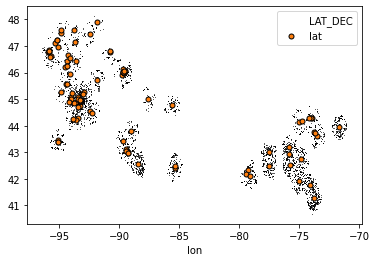

In [8]:
fig,ax = plt.subplots()
dfstations.plot('LON_DEC','LAT_DEC',ls='none', alpha=0.8,marker='.',ax=ax,markersize=2,markerfacecolor='k',markeredgecolor='none')
dftopN.plot('lon','lat',ls='none',marker='o',ax=ax,markerfacecolor='C1',markeredgecolor='k',markersize=5)

### Download weather data
- Looking for weather stations with data in specific date range between start and end date
- including attributes/flags (data quality)

"MF,QF,SF,TOS" gets added to every observation

MF: Measurement flag

QF: Quality flag (any non-blank -- generally means data failed a QA check)

SF: Source flag

TOS: Time of observation (HHMM)

In [9]:
dftopN

,lakecode,lake,start_date,end_date,lat,lon,Distance,Hylak_id,Match,Lake_name,...,Vol_res,Vol_src,Depth_avg,Dis_avg,Res_time,Elevation,Slope_100,Wshd_area,Pour_long,Pour_lat
0,DMR1,mendota,1852,2019,43.12800,-89.42000,0.000000,9086.0,True,Tenny Park Locks,...,197.4,2.0,4.8,6.047,377.8,258.00,2.61,640.1,-89.377833,43.086984
1,DMR2,monona,1851,2019,43.06700,-89.36600,0.000000,9087.0,True,NaN,...,0.0,3.0,6.6,6.856,149.6,256.00,2.36,729.0,-89.339804,43.053292
2,HB01,mirror,1968,2006,43.94400,-71.69300,0.000000,1047119.0,True,NaN,...,0.0,3.0,4.8,0.024,281.9,217.00,5.64,0.9,-71.693675,43.944025
3,JD01,kegonsa,1902,2007,42.96600,-89.25100,0.000000,9091.0,True,NaN,...,0.0,3.0,5.5,9.135,87.2,256.00,2.03,986.7,-89.223839,42.964546
4,JGL01,spirit,1943,2008,43.47700,-95.10200,0.000000,9065.0,True,NaN,...,0.0,3.0,2.3,0.980,571.9,425.00,0.84,189.7,-95.103860,43.445607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,xKB1820,turtle,1964,2016,47.61765,-94.86755,0.000000,105222.0,False,NaN,...,NaN,NaN,NaN,NaN,NaN,410.15,NaN,NaN,NaN,NaN
96,xKB1881,upper_prior,1962,2017,44.71411,-93.44694,0.000000,109902.0,False,NaN,...,NaN,NaN,NaN,NaN,NaN,274.66,NaN,NaN,NaN,NaN
97,xKB1921,washington,1949,2017,44.25335,-93.87293,90.411844,110415.0,True,NaN,...,0.0,3.0,4.9,1.283,257.8,297.00,1.75,180.6,-93.892546,44.266087
98,xKB1946,west_mcdonald,1967,2016,46.58214,-95.78864,0.000000,107079.0,False,NaN,...,NaN,NaN,NaN,NaN,NaN,412.91,NaN,NaN,NaN,NaN


In [12]:
for i,row in dftopN.iterrows():
    lat,lon = row.lat, row.lon
    start_date = f'1 January {row.start_date}'
    end_date = f'31 December {row.end_date}'
    print(row.lake)
    print(start_date, end_date)
    stations = download_weather_data(lat,lon,dfstations, 
                                     dist=weatherstation_dist, 
                                     start_date=start_date,
                                     end_date=end_date,
                                     download_all=True, 
                                     includeAttributes='1')
    print('waiting for next lake')

mendota
1 January 1852 31 December 2019
100 stations within 50 km of (43.128,-89.420)
waiting for next lake
monona
1 January 1851 31 December 2019
104 stations within 50 km of (43.067,-89.366)
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1WIRK0007.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00472869.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1WIJF0016.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1WIJF0013.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1WIJF0017.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00474108.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00475473.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00471078.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1WIGN0008.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00470892.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/cs

Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NHCR0014.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NHBK0017.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00430724.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1VTOG0003.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1VTOG0013.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00275997.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NHCR0020.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00435044.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USR0000NWMT.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00431565.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00279184.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NHGR0047.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NHCR0011.csv
Saved to /Volumes/My Pass

Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00478610.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1WIVL0011.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00475516.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00470786.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00477480.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1WIVL0013.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00477092.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1WIVL0009.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1WIVL0001.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00474320.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00475352.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00476939.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00471155.csv
Saved to /Volumes/My Pass

Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00474894.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1WISR0006.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1WIBR0008.csv
waiting for next lake
spruce
1 January 1959 31 December 2019
48 stations within 50 km of (46.053,-89.567)
waiting for next lake
big_green
1 January 1939 31 December 2020
52 stations within 50 km of (43.804,-89.028)
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1WIGL0002.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1WIGL0003.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1WIGL0004.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00475096.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00473214.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00477202.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00470740.csv
Saved to /Volumes/My Passport for M

Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00472412.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00477314.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1ILMCH088.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1WIKN0017.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1WIWW0027.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1ILMCH047.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1ILMCH013.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1WIRC0025.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1ILBN0014.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1ILMCH034.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1WIWW0026.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1WIRC0016.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1ILMCH029.csv
Saved to /Volumes/My Pass

Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1ILMCH009.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1ILMCH096.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00470696.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1ILMCH043.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1ILWN0003.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1ILLK0076.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1ILMCH090.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1ILBN0005.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1ILLK0042.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1WIWK0019.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1ILMCH012.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1WIJF0022.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00115961.csv
Saved to /Volumes/My Pass

Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1VTRT0008.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00431580.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00301713.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00301708.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00436995.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00308104.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00304537.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1VTRT0015.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00437098.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00301771.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00306765.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00303125.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00431433.csv
Saved to /Volumes/My Pass

Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00307035.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYDT0009.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00303251.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYDT0035.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYDT0002.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00308352.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYUL0002.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYDT0028.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYDT0005.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00301615.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USW00014714.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYUL0004.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYUL0019.csv
Saved to /Volumes/My Pass

Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00304796.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYHR0016.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00304673.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00307088.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYHR0004.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00307382.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00308338.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYHR0019.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00301987.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYDL0034.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00304791.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00301589.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00301593.csv
Saved to /Volumes/My Pass

Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00301388.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00306184.csv
waiting for next lake
brant
1 January 1892 31 December 2020
48 stations within 50 km of (43.714,-73.706)
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1VTAD0015.csv
waiting for next lake
cassadaga_lower
1 January 1970 31 December 2005
59 stations within 50 km of (42.346,-79.317)
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00307772.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00303033.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00300259.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYCQ0022.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00302197.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00306747.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYCQ0006.csv
Saved to /Volumes/My Passport 

Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00307728.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00303773.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00309049.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYMR0057.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYON0007.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYMR0067.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00309640.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYWN0020.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYON0017.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00304684.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00303881.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYMR0029.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYON0018.csv
Saved to /Volumes/My Pass

Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00301466.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYDL0006.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00302302.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYDL0008.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00367186.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00362951.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1PAWN0035.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00302039.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1PAWN0014.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1PAPK0004.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1PAWN0026.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYDL0005.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00305743.csv
Saved to /Volumes/My Pass

Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1CTFR0043.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1CTFR0064.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00285104.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NJBG0010.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00304613.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NJBG0006.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00061093.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NJBG0005.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NJBG0031.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1CTFR0078.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00065893.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1CTFR0041.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00302291.csv
Saved to /Volumes/My Pass

Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYMD0009.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYBM0002.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00301414.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYCN0016.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYMD0011.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYCR0010.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00301415.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00300360.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00307195.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00302351.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00301799.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00308614.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00305512.csv
Saved to /Volumes/My Pass

Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00301442.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00300816.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00300817.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYAL0002.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00304698.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00309533.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYSY0008.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00300183.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00306746.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00306510.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYST0010.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00300175.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYST0006.csv
Saved to /Volumes/My Pass

Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYOG0014.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYMD0020.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYOG0067.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00306579.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYOD0002.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00300379.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00306300.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00300608.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYOD0008.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00309248.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYOD0045.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYMD0014.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1NYOS0026.csv
Saved to /Volumes/My Pass

Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00200864.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MIET0014.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MIAN0008.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MIVB0007.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MIKN0017.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00201476.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MIKN0094.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MIKN0049.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00208184.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MIKN0043.csv
waiting for next lake
fair
1 January 1955 31 December 2019
81 stations within 50 km of (42.485,-85.332)
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MIIN0004.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MIKN0005.

Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNHN0201.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNHN0051.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNWR0019.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNHN0050.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNWR0006.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNHN0200.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNHN0231.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNHN0055.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNHN0038.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNHN0089.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNHN0289.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNHN0030.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNHN0060.csv
Saved to /Volumes/My Pass

Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNSC0037.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNHN0044.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNMC0017.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNHN0062.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNSC0047.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNHN0155.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNHN0085.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNWR0041.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNHN0178.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNHN0281.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNHN0035.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNDK0128.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNHN0065.csv
Saved to /Volumes/My Pass

Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNLS0013.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNAA0045.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNDK0020.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNLS0003.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNAA0006.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNDK0025.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNMC0005.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNSH0012.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNMC0006.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNAA0036.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNDK0087.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNDK0067.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNDK0053.csv
Saved to /Volumes/My Pass

Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00212146.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNOT0004.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNCY0018.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00218191.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00213588.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNCY0017.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNOT0023.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNOT0018.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNCY0025.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNCY0020.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00217149.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNOT0033.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNCY0019.csv
Saved to /Volumes/My Pass

Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNGH0030.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00215224.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1WIPC0009.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00476470.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1WIPC0007.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00219237.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1WIPP0001.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00219231.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00219235.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNDK0093.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNGH0009.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00216777.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1WIPC0004.csv
Saved to /Volumes/My Pass

Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNMC0010.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00215571.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00211065.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00213965.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNMC0003.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00218025.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNMC0016.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNLS0004.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNMC0012.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNMC0020.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNMC0023.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNMK0011.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNMC0013.csv
Saved to /Volumes/My Pass

Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MIBZ0002.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MILL0001.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00204257.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USR0000MBRR.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00202782.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00208167.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00208034.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00200660.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MILL0003.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00206007.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00200662.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00205086.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00205043.csv
Saved to /Volumes/My Pass

Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNRC0036.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNWG0019.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNWG0021.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNWG0008.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNLS0001.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNWG0066.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNRC0008.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNWG0024.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNWG0018.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNWG0014.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNGH0015.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNWG0046.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNRC0028.csv
Saved to /Volumes/My Pass

Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00218692.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNWC0012.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00216287.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNSE0005.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNSE0011.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNSE0002.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNSE0006.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNSE0990.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNSE0015.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNSE0016.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNBU0026.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNWC0002.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNLS0006.csv
Saved to /Volumes/My Pass

Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNCG0027.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNCG0043.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00477464.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00218204.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1WIPK0024.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNCG0016.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00218986.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1WIPK0025.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00211227.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1WIPK0004.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1WISC0039.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1WISC0044.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00475948.csv
Saved to /Volumes/My Pass

169 stations within 50 km of (44.996,-94.023)
waiting for next lake
medicine
1 January 1940 31 December 2017
445 stations within 50 km of (45.007,-93.421)
waiting for next lake
pallette
1 January 1959 31 December 2019
45 stations within 50 km of (46.067,-89.604)
waiting for next lake
peltier
1 January 1979 31 December 2017
385 stations within 50 km of (45.187,-93.056)
waiting for next lake
pepin
1 January 1842 31 December 2017
80 stations within 50 km of (44.492,-92.279)
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00210559.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNOL0049.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNOL0012.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/USC00475563.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1MNOL0030.csv
Saved to /Volumes/My Passport for Mac/WeatherData/NOAA/csv/US1WIDN0009.csv
waiting for next lake
pierz
1 January 1940 31 December 2017
59 stations wi